In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

In [362]:
class RNN():

    def __init__(self,**kwargs):

        self.N = kwargs.get('N',500)
        self.cf = kwargs.get('cf',.1)
        self.cf_in = kwargs.get('cf_in',1.)
        self.a_r = np.ones((self.N)) * kwargs.get('a_r',1.)
        self.a_e = np.ones((self.N)) * kwargs.get('a_e',1.)
        self.b = np.ones((self.N)) * kwargs.get('b',0.)
        self.mu_w = kwargs.get('mu_w',0.)
        self.mu_w_in = kwargs.get('mu_w_in',0.)

        self.tau = 1.*kwargs.get('tau',1.)

        self.dim_in = kwargs.get('dim_in',1)
        self.dim_out = kwargs.get('dim_out',1)

        self.eps_a_r = np.ones((self.N)) * kwargs.get('eps_a_r',0.001)
        self.eps_a_e = np.ones((self.N)) * kwargs.get('eps_a_e',0.001)
        self.eps_w_out = np.ones((self.dim_out,self.N+1))
        self.eps_w_out[:,0] *= 1.
        self.eps_w_out *= kwargs.get('eps_w_out',0.001)
        self.eps_b = np.ones((self.N)) * kwargs.get('eps_b',0.001)
        self.eps_y_mean = np.ones((self.N)) * kwargs.get('eps_y_mean',0.0001)
        self.eps_y_std = np.ones((self.N)) * kwargs.get('eps_y_std',0.001)
        self.eps_X_r_mean = np.ones((self.N)) * kwargs.get('eps_X_r_mean',0.001)

        self.y_mean_target = np.ones((self.N)) * kwargs.get('y_mean_target',0.05)
        self.y_std_target = np.ones((self.N)) * kwargs.get('y_std_target',.5)

        self.W = np.random.normal(self.mu_w,1./(self.N*self.cf)**.5,(self.N,self.N))*(np.random.rand(self.N,self.N) <= self.cf)
        self.W[range(self.N),range(self.N)] = 0.

        self.w_in = np.random.normal(self.mu_w_in,1.,(self.N,self.dim_in))
        self.w_out = np.random.rand(self.dim_out,self.N+1)*0.01
        self.w_out[:,0] = 0.

    def f(self,x):
        #return (np.tanh(2.*x)+1.)/2.
        return np.tanh(x)

    def df_x(self,x):
        f = self.f(x)
        #return 4.*f*(1.-f)
        return 1.-f**2.

    def df_y(self,y):
        #return 4.*y*(1.-y)
        return 1.-y**2.

    def check_data_in_comp(self,data):

        if len(data.shape)==1:
            if self.dim_in != 1:
                print("input dimensions do not fit!")
                sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.dim_in):
            print("input dimensions do not fit!")
            sys.exit()

        return data

    def check_data_out_comp(self,data):

        if len(data.shape)==1:
            if self.dim_out != 1:
                print("output dimensions do not fit!")
                #sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.dim_out):
            print("output dimensions do not fit!")
            #sys.exit()

        return data

    def learn_w_out_trial(self,u_in,u_target,reg_fact=.01,show_progress=False,T_prerun=0):

        u_in = self.check_data_in_comp(u_in)
        u_target = self.check_data_out_comp(u_target)

        n_t = u_in.shape[0]


        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.


        y[0,1:] = self.f(self.a_e*(self.w_in @ u_in[0,:]) - self.b)


        for t in tqdm(range(1,n_t),disable=not(show_progress)):

            y[t,1:] = self.f(self.a_r*(self.W.dot(y[t-1,1:])) + self.a_e*(self.w_in @ u_in[t,:]) - self.b)

        self.w_out[:,:] = (np.linalg.inv(y[T_prerun:,:].T @ y[T_prerun:,:] + reg_fact*np.eye(self.N+1)) @ y[T_prerun:,:].T @ u_target[T_prerun:,:]).T

    def run_learn(self,u_in,u_out,T_skip_rec = 1,show_progress=True):

        u_in = self.check_data_in_comp(u_in)
        u_out = self.check_data_out_comp(u_out)

        T = u_in.shape[0]

        T_rec = int(T/T_skip_rec)

        #### Recorders
        y_rec = np.ndarray((T_rec,self.N+1))
        X_r_rec = np.ndarray((T_rec,self.N))
        X_e_rec = np.ndarray((T_rec,self.N))
        O_rec = np.ndarray((T_rec,self.dim_out))
        err_rec = np.ndarray((T_rec,self.dim_out))
        a_r_rec = np.ndarray((T_rec,self.N))
        a_e_rec = np.ndarray((T_rec,self.N))
        delta_a_r_rec = np.ndarray((T_rec))
        delta_a_e_rec = np.ndarray((T_rec))
        w_out_rec = np.ndarray((T_rec,self.dim_out,self.N+1))
        ####

        y = np.ndarray((self.N+1))
        y[0] = 1.

        X_r = np.ndarray((self.N))
        X_e = np.ndarray((self.N))

        O = np.ndarray((self.dim_out))

        err = np.ndarray((self.dim_out))

        sign_err = np.ndarray((self.dim_out))

        dyda_r = np.zeros((self.N))
        dyda_e = np.zeros((self.N))

        delta_a_r = 0.#np.ndarray((self.N))
        delta_a_e = 0.#np.ndarray((self.N))

        delta_w_out = np.ndarray((self.dim_out,self.N+1))

        X_r[:] = np.random.normal(0.,1.,(self.N))
        X_e[:] = self.w_in @ u_in[0,:]

        y[1:] = self.f(self.a_r * X_r + self.a_e * X_e - self.b)

        O[:] = self.w_out @ y
        err[:] = O - u_out[0,:]

        #### Assign for t=0
        y_rec[0,:] = y
        X_r_rec[0,:] = X_r
        X_e_rec[0,:] = X_e
        O_rec[0,:] = O
        err_rec[0,:] = err
        a_r_rec[0,:] = self.a_r
        a_e_rec[0,:] = self.a_e
        w_out_rec[0,:,:] = self.w_out
        delta_a_r_rec[0] = 0.
        delta_a_e_rec[0] = 0.
        ####

        for t in tqdm(range(1,T),disable=not(show_progress)):

            X_r = self.W @ y[1:]
            X_e = self.w_in @ u_in[t,:]

            y[1:] = self.f(self.a_r * X_r + self.a_e * X_e - self.b)

            #### calc err
            O = self.w_out @ y
            err = O - u_out[t,:]

            sign_err = 2.*(err > 0.) - 1.
            ####

            #### update gains
            #dyda_r = self.df_y(y[1:])*(X_r + self.a_r[0]*self.W @ dyda_r)
            #dyda_e = self.df_y(y[1:])*(X_e + self.a_r[0]*self.W @ dyda_e)

            dyda_r = self.df_y(y[1:])*X_r
            dyda_e = self.df_y(y[1:])*X_e

            #delta_a_r = -(self.w_out[:,1:].T @ err) * self.df_y(y[1:]) * X_r
            #delta_a_e = -(self.w_out[:,1:].T @ err) * self.df_y(y[1:]) * X_e

            delta_a_r = -(err * (self.w_out[:,1:] @ dyda_r)).sum()
            delta_a_e = -(err * (self.w_out[:,1:] @ dyda_e)).sum()

            self.a_r += self.eps_a_r * delta_a_r
            self.a_e += self.eps_a_e * delta_a_e

            self.a_r = np.maximum(0.01,self.a_r)
            self.a_e = np.maximum(0.01,self.a_e)
            ####

            #### update readout weights
            delta_w_out = -np.outer(err,y)
            #delta_w_out = np.outer(u_out[t,:],y) - self.w_out * (y**2.)
            self.w_out += self.eps_w_out * delta_w_out

            #self.w_out[:,1:] = np.maximum(0.,self.w_out[:,1:])
            ####

            #### record
            if t%T_skip_rec == 0:

                t_rec = int(t/T_skip_rec)

                y_rec[t_rec,:] = y
                X_r_rec[t_rec,:] = X_r
                X_e_rec[t_rec,:] = X_e
                O_rec[t_rec,:] = O
                err_rec[t_rec,:] = err
                a_r_rec[t_rec,:] = self.a_r
                a_e_rec[t_rec,:] = self.a_e
                delta_a_r_rec[t_rec] = delta_a_r
                delta_a_e_rec[t_rec] = delta_a_e
                w_out_rec[t_rec,:,:] = self.w_out

        t_ax = np.array(range(T_rec))*T_skip_rec

        return t_ax,y_rec,X_r_rec,X_e_rec,O_rec,err_rec,w_out_rec,a_r_rec,a_e_rec,delta_a_r_rec,delta_a_e_rec

    def predict_data(self,data,return_reservoir_rec=False,show_progress=True):

        data = self.check_data_in_comp(data)

        n_t = data.shape[0]

        u_in = data

        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.

        y[0,1:] = self.f(self.a_e*(self.w_in @ u_in[0,:]) - self.b)

        for t in tqdm(range(1,n_t),disable=not(show_progress)):

            y[t,1:] = self.f(self.a_r*(self.W.dot(y[t-1,1:])) + self.a_e*(self.w_in @ u_in[t,:]) - self.b)

        out = (self.w_out @ y.T).T
        if self.dim_out == 1:
            out = out[:,0]

        if return_reservoir_rec:
            return (out,y)
        else:
            return out

    def run_hom_adapt(self,u_in=None,sigm_e=1.,T_skip_rec = 1,T=None,show_progress=True):

        if u_in is not None:
            mode = 'real_input'
            u_in = self.check_data_in_comp(u_in)
            T = u_in.shape[0]
        else:
            mode = 'gaussian_noise_input'
            if T == None:
                T = self.N*50

        T_rec = int(T/T_skip_rec)

        #### Recorders
        y_rec = np.ndarray((T_rec,self.N))
        X_r_rec = np.ndarray((T_rec,self.N))
        X_e_rec = np.ndarray((T_rec,self.N))
        a_r_rec = np.ndarray((T_rec,self.N))
        a_e_rec = np.ndarray((T_rec,self.N))
        b_rec = np.ndarray((T_rec,self.N))
        y_mean_rec = np.ndarray((T_rec,self.N))
        y_std_rec = np.ndarray((T_rec,self.N))
        ####

        y = np.ndarray((self.N))
        y_mean = np.ndarray((self.N))
        y_var = np.ndarray((self.N))

        X_r = np.ndarray((self.N))
        X_e = np.ndarray((self.N))

        X_r[:] = np.random.normal(0.,1.,(self.N))
        #X_e[:] = self.w_in @ u_in[0,:]
        if mode == 'real_input':
            X_e = self.w_in @ u_in[0,:]
        else:
            X_e = np.random.normal(0.,sigm_e,(self.N))

        y = self.f(self.a_r * X_r + self.a_e * X_e - self.b)
        y_mean = y[:]
        y_var[:] = 0.

        delta_a = np.zeros((self.N))
        delta_b = np.zeros((self.N))

        #### Assign for t=0
        y_rec[0,:] = y
        X_r_rec[0,:] = X_r
        X_e_rec[0,:] = X_e
        a_r_rec[0,:] = self.a_r
        a_e_rec[0,:] = self.a_e
        b_rec[0,:] = self.b
        y_mean_rec[0,:] = y_mean
        y_std_rec[0,:] = y_var**.5
        ####

        for t in tqdm(range(1,T),disable=not(show_progress)):

            X_r = self.W @ y
            if mode == 'real_input':
                X_e = self.w_in @ u_in[t,:]
            else:
                X_e = np.random.normal(0.,sigm_e,(self.N))

            y = self.f(self.a_r * X_r + self.a_e * X_e - self.b)

            y_mean += self.eps_y_mean * ( -y_mean + y)
            y_var += self.eps_y_std * ( -y_var + (y-y_mean)**2.)

            delta_a = (self.y_std_target**2. - (y-y_mean)**2.)
            delta_b = (y - self.y_mean_target)

            self.a_r += self.eps_a_r * delta_a
            self.a_e += self.eps_a_e * delta_a

            self.a_r = np.maximum(0.,self.a_r)
            self.a_e = np.maximum(0.,self.a_e)

            self.b += self.eps_b * delta_b

            #### record
            if t%T_skip_rec == 0:

                t_rec = int(t/T_skip_rec)

                y_rec[t_rec,:] = y
                X_r_rec[t_rec,:] = X_r
                X_e_rec[t_rec,:] = X_e
                a_r_rec[t_rec,:] = self.a_r
                a_e_rec[t_rec,:] = self.a_e
                b_rec[t_rec,:] = self.b
                y_mean_rec[t_rec,:] = y_mean
                y_std_rec[t_rec,:] = y_var**.5

        return y_rec, X_r_rec, X_e_rec, a_r_rec, a_e_rec, b_rec, y_mean_rec, y_std_rec

    def run_sample(self,u_in=None,sigm_e=1.,T_skip_rec = 1,T=None,show_progress=True):

        if u_in is not None:
            mode = 'real_input'
            u_in = self.check_data_in_comp(u_in)
            T = u_in.shape[0]
        else:
            mode = 'gaussian_noise_input'
            if T == None:
                T = self.N*50

        T_rec = int(T/T_skip_rec)

        #### Recorders
        y_rec = np.ndarray((T_rec,self.N))
        X_r_rec = np.ndarray((T_rec,self.N))
        X_e_rec = np.ndarray((T_rec,self.N))
        ####

        y = np.ndarray((self.N))

        X_r = np.ndarray((self.N))
        X_e = np.ndarray((self.N))

        X_r[:] = np.random.normal(0.,1.,(self.N))
        #X_e[:] = self.w_in @ u_in[0,:]
        if mode == 'real_input':
            X_e = self.w_in @ u_in[0,:]
        else:
            X_e = np.random.normal(0.,sigm_e,(self.N))

        y = self.f(self.a_r * X_r + self.a_e * X_e - self.b)

        #### Assign for t=0
        y_rec[0,:] = y
        X_r_rec[0,:] = X_r
        X_e_rec[0,:] = X_e
        ####

        for t in tqdm(range(1,T),disable=not(show_progress)):

            X_r = self.W @ y
            if mode == 'real_input':
                X_e = self.w_in @ u_in[t,:]
            else:
                X_e = np.random.normal(0.,sigm_e,(self.N))

            y = self.f(self.a_r * X_r + self.a_e * X_e - self.b)


            #### record
            if t%T_skip_rec == 0:

                t_rec = int(t/T_skip_rec)

                y_rec[t_rec,:] = y
                X_r_rec[t_rec,:] = X_r
                X_e_rec[t_rec,:] = X_e


        return y_rec, X_r_rec, X_e_rec
    
    def adapt_diff_act_rec_pot(self,u_in=None,sigm_e=1.,T_skip_rec = 1,T=None,show_progress=True,alpha_mix=0.9):
        
        if u_in is not None:
            mode = 'real_input'
            u_in = self.check_data_in_comp(u_in)
            T = u_in.shape[0]
        else:
            mode = 'gaussian_noise_input'
            if T == None:
                T = self.N*50

        T_rec = int(T/T_skip_rec)

        #### Recorders
        y_rec = np.ndarray((T_rec,self.N))
        X_r_rec = np.ndarray((T_rec,self.N))
        X_r_mean_rec = np.ndarray((T_rec,self.N))
        X_e_rec = np.ndarray((T_rec,self.N))
        a_r_rec = np.ndarray((T_rec,self.N))
        #sigm_squ_t_rec = np.ndarray((T_rec,self.N))
        ####

        y = np.ndarray((self.N))

        X_r = np.ndarray((self.N))
        X_e = np.ndarray((self.N))
        X_r_mean = np.ndarray((self.N))
        
        X_r[:] = self.a_r * np.random.normal(0.,1.,(self.N))
        X_r_mean[:] = X_r
        #X_e[:] = self.w_in @ u_in[0,:]
        if mode == 'real_input':
            X_e = self.a_e * (self.w_in @ u_in[0,:])
        else:
            X_e = self.a_e * np.random.normal(0.,sigm_e,(self.N))

        y = self.f(X_r + X_e - self.b)

        #### Assign for t=0
        y_rec[0,:] = y
        X_r_rec[0,:] = X_r
        X_r_mean_rec[0,:] = X_r_mean
        X_e_rec[0,:] = X_e
        a_r_rec[0,:] = self.a_r
        #sigm_squ_t_rec[0,:] = self.y_std_target
        ####

        for t in tqdm(range(1,T),disable=not(show_progress)):

            X_r = self.a_r * (self.W @ y)
            if mode == 'real_input':
                X_e = self.a_e * (self.w_in @ u_in[t,:])
            else:
                X_e = self.a_e * np.random.normal(0.,sigm_e,(self.N))

            y = self.f(X_r + X_e - self.b)
            
            X_r_mean += self.eps_X_r_mean * (-X_r_mean + X_r)
            
            #self.y_std_target += self.eps_y_std * ( (y**2.).mean() - (self.a_r**2.*X_r**2.).mean())
            #self.a_r += self.eps_a_r * (self.a_r * ( alpha_mix*((y**2.).mean() - (self.a_r**2.*X_r**2.).mean()) + (1.-alpha_mix)*(y**2. - self.a_r**2.*X_r**2.) ) + 0.)
            self.a_r += self.eps_a_r * (( y**2. - X_r**2.) + 0.)
            
            self.a_r = np.maximum(0.,self.a_r)
            
            #### record
            if t%T_skip_rec == 0:

                t_rec = int(t/T_skip_rec)

                y_rec[t_rec,:] = y
                X_r_rec[t_rec,:] = X_r
                X_e_rec[t_rec,:] = X_e
                X_r_mean_rec[t_rec,:] = X_r_mean
                
                a_r_rec[t_rec,:] = self.a_r
                #sigm_squ_t_rec[t_rec,:] = self.y_std_target

        return y_rec, X_r_rec, X_r_mean_rec, X_e_rec, a_r_rec#, sigm_squ_t_rec

In [363]:
rnn = RNN(eps_a_r=0.001,eps_X_r_mean=0.001)
rnn.a_r[:] = 1.5#np.random.rand(rnn.N)

In [364]:
y, X_r, X_r_mean, X_e, a_r = rnn.adapt_diff_act_rec_pot(np.random.randint(0,2,150000),alpha_mix=.0,T_skip_rec=10)

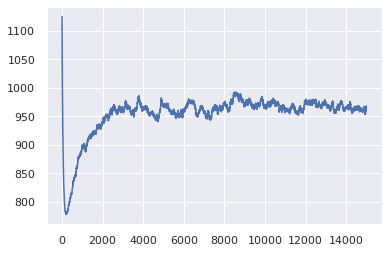

In [365]:
plt.plot((a_r**2.).sum(axis=1))
plt.show()

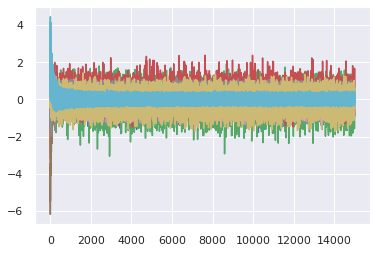

In [369]:
plt.plot(X_r[:,:10]-X_r_mean[:,:10])
plt.show()

In [367]:
l_start = np.linalg.eigvals((rnn.W.T * a_r[0,:]).T)
l_end = np.linalg.eigvals((rnn.W.T * a_r[-1,:]).T)

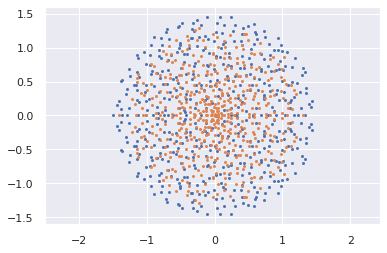

In [368]:
plt.plot(l_start.real,l_start.imag,'.')
plt.plot(l_end.real,l_end.imag,'.')
plt.axis('equal')
plt.show()

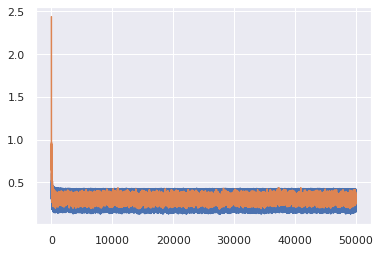

In [316]:
plt.plot(np.linalg.norm(y,axis=1)**2./rnn.N)
plt.plot(np.linalg.norm(X_r,axis=1)**2./rnn.N)